In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from string import punctuation
from functools import partial
from itertools import chain

import nltk
import pymorphy2
from pymorphy2.tokenizers import simple_word_tokenize
from joblib import Parallel, parallel_backend, delayed
from tqdm import tqdm

import torch
from sklearn.metrics import accuracy_score, classification_report

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Selected device: {device}')

Selected device: cuda


In [3]:
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/avagadro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


__read & clean data__

In [4]:
raw_train = pd.read_csv('data/train.csv', index_col='id')
raw_valid = pd.read_csv('data/val.csv', index_col='id')

In [5]:
raw_train['class'].value_counts()

1    92063
0    89404
Name: class, dtype: int64

In [6]:
raw_valid['class'].value_counts()

1    11449
0    11234
Name: class, dtype: int64

In [7]:
def tokenize(x: pd.Series, morph=pymorphy2.MorphAnalyzer()):
    index = x.index.copy()
    x = x.copy()
    # clean
    x = x.str.lower()
    x = x.str.replace(r'(@\S*)\b', ' ', regex=True)     # remove usernames
    x = x.str.replace(r'(http\S*)\b', ' ', regex=True)
    smiles = x.str.extractall(rf'((?::|;)[{punctuation}]+)\s').droplevel(1).groupby('id')[0].agg(list)
    x = x.str.replace(rf'[{punctuation}]', ' ', regex=True)
    x = x.str.replace(r'\s+', ' ', regex=True)
    # tokenize
    x = x.apply(simple_word_tokenize)
    # lemmatize
    with parallel_backend('loky'):
        x = Parallel()(delayed(lambda tk: [morph.parse(t)[0].normal_form for t in tk])(item) for item in tqdm(x, desc='lemmatizing'))
    # drop stopwords
    with parallel_backend('loky'):
        x = Parallel()(delayed(lambda tk: [t for t in tk if t not in STOPWORDS])(item) for item in tqdm(x, desc='dropping stopwords'))
    # add smiles back
    return pd.Series(x, index=index)

# take part for increasing development
np.random.seed(11)
FRAC = 0.05
train_tokens = tokenize(raw_train['text'].sample(frac=FRAC, replace=False))
valid_tokens = tokenize(raw_valid['text'].sample(frac=FRAC, replace=False))

train_labels = raw_train.loc[train_tokens.index, 'class']
valid_labels = raw_valid.loc[valid_tokens.index, 'class']

dropping stopwords: 100%|██████████| 1134/1134 [00:00<00:00, 17953.81it/s]


In [8]:
all_tokens = pd.Series(chain(*train_tokens))
all_tokens.nunique(), all_tokens.size

(15371, 64988)

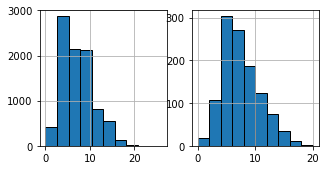

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))
train_tokens.apply(len).hist(ax=ax[0], edgecolor='black')
valid_tokens.apply(len).hist(ax=ax[1], edgecolor='black')
plt.show()

In [10]:
# build tokens dictionary
class DictVectorizer:
    def __init__(self, vecsize, sticky_edge='start'):
        self.id2token = None
        self.token2id = None
        self.vecsize = vecsize
        self.sticky_edge = sticky_edge

    def vectorize_item(self, tokens):
        vector = [self.token2id[tk] for tk in tokens if tk in self.token2id]          # vectorize
        if len(vector) > self.vecsize:
            return vector[:self.vecsize] if self.sticky_edge == 'start' else vector[-self.vecsize:]
        vector.extend([0] * (self.vecsize - len(vector)))
        return vector
    
    def fit(self, X, dictsize='full'):
        all_tokens = [token for row in X for token in row]
        freqdist = nltk.probability.FreqDist(all_tokens)
        filtered_tokens = [token for token, _ in freqdist.most_common(len(freqdist) if dictsize == 'full' else dictsize)]
        self.id2token = dict(enumerate(filtered_tokens))
        self.token2id = {v: k for k, v in self.id2token.items()}
        return self
    
    def transform(self, X: pd.Series):
        with parallel_backend('loky'):
            res = Parallel()(delayed(self.vectorize_item)(item) for item in tqdm(X, desc='vectorizing'))
        return pd.Series(res, index=X.index)

VEC_SIZE = 10
dictionary = DictVectorizer(vecsize=VEC_SIZE).fit(train_tokens)
train = dictionary.transform(train_tokens)
valid = dictionary.transform(valid_tokens)

vectorizing: 100%|██████████| 1134/1134 [00:00<00:00, 1894.23it/s]


In [11]:
class SimpleNLPDataset(torch.utils.data.Dataset):
    def __init__(self, vecs, lbs):
        self.vecs = vecs
        self.lbs = lbs

    def __getitem__(self, index):
        # return torch.as_tensor(self.vecs[index]), torch.as_tensor(self.lbs[index].reshape(1, -1))
        return torch.as_tensor(self.vecs[index]), torch.as_tensor(self.lbs[index])
    
    def __len__(self):
        return self.vecs.shape[0]

BATCH_SIZE = 256
# make datasets
train_dataset = SimpleNLPDataset(train.values, train_labels.values)
valid_dataset = SimpleNLPDataset(valid.values, valid_labels.values)
# make loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
class Trainable:
    def fit(self, loader, optim, crit, *, epochs=5, dev='cpu', eval_params=None):
        """
        :param loader - data loader
        :param optim - optimizer
        :param crit - criterion
        :param epochs
        :param device
        :param eval_params - predict() parameters for evaluation
        """
        self.crit = crit
        self.dev = dev
        if not eval_params:
            eval_params = dict()
        self.train()
        
        for ep in range(epochs):
            sum_loss, items = 0.0, 0
            pbar = tqdm(enumerate(loader), total=len(loader), desc=f'Epoch {ep + 1}/{epochs}')
            for i, batch in pbar:
                inputs, labels = batch[0].to(dev), batch[1].to(dev)
                optim.zero_grad()
                outputs = self(inputs)
                loss = crit(outputs, labels.float())
                loss.backward()
                optim.step()

                sum_loss += loss.item()
                items += len(labels)
                pbar.set_postfix({'cumulative loss per item': sum_loss / items})

                # evaluate
                if (i + 1 == len(loader)) and eval_params:
                    self.eval()
                    valid_loader = eval_params.get('valid_loader')
                    pbar.set_postfix_str('calculating final loss...')

                    train_result = self.predict_(loader, **eval_params)
                    report = {'loss': train_result[1], 'metric': 'n/a' if len(train_result) == 2 else train_result[2]}

                    if valid_loader is not None:
                        valid_result = self.predict_(valid_loader, **eval_params)
                        report = {'loss': f'{train_result[1]:03f}/{valid_result[1]:03f}',
                                  'metric': 'n/a' if len(train_result) == 2 else f'{train_result[2]:03f}/{valid_result[2]:03f}'}
                    pbar.set_postfix(report)
                    self.train()
        print('\nDone.')

    def predict_(self, loader, *, metric=None, threshold=0.5, **kwargs):
        if not hasattr(self, 'dev'):
            raise AttributeError('Model is not trained.')
        self.eval()
        loss = 0
        for i, batch in enumerate(loader):
            inputs, labels = batch[0].to(self.dev), batch[1].to(self.dev)
            outputs = self(inputs)
            predicts = torch.cat([predicts, outputs]) if i > 0 else outputs
            true_labels = torch.cat([true_labels, labels]) if i > 0 else labels

            loss += self.crit(outputs, labels.float()).item() / len(loader)
        result = [predicts, loss]
        if metric:
            pred_labels = torch.squeeze(predicts > threshold) * 1
            result.append(metric(true_labels.cpu(), pred_labels.detach().cpu()))
        return result

### conv

In [18]:
class ConvNet(torch.nn.Module, Trainable):
    def __init__(self, dict_size, embedding_dim=128, drop=0.3, num_classes=1):
        super().__init__()
        self.embedding = torch.nn.Embedding(dict_size, 2 * embedding_dim)
        self.conv_1 = torch.nn.Conv1d(2 * embedding_dim, embedding_dim, kernel_size=2)

        self.linear = torch.nn.Linear(embedding_dim, num_classes)
        self.dp = torch.nn.Dropout(drop)
        
    def forward(self, x):        
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv_1(x)
        x = torch.relu(x)
        x = torch.max_pool1d(x, 2)
        x = self.dp(x)
        x = torch.max(x, axis=2).values
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x.flatten()

In [19]:
DICT_SIZE = all_tokens.nunique()

torch.manual_seed(11)       # just in case
convmodel = ConvNet(dict_size=DICT_SIZE, embedding_dim=256, drop=0.05, num_classes=1).to(device)

optimizer = torch.optim.Adam(convmodel.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

eval_params = {
    'softmax': True,
    'metric': accuracy_score,
    'valid_loader': valid_loader
}
convmodel.fit(train_loader, optimizer, criterion, epochs=5, dev=device, eval_params=eval_params)

Epoch 5/5: 100%|██████████| 36/36 [00:00<00:00, 56.16it/s, loss=0.011244/1.882303, metric=0.996693/0.654321]


Done.


In [ ]:
convpred = (convmodel.predict_(valid_loader)[0] > 0.5) * 1
print(classification_report(valid_labels.values, convpred.detach().cpu()))

              precision    recall  f1-score   support

           0       0.64      0.69      0.66       564
           1       0.67      0.62      0.64       570

    accuracy                           0.65      1134
   macro avg       0.66      0.65      0.65      1134
weighted avg       0.66      0.65      0.65      1134



### RNN

In [20]:
class RNNNet(torch.nn.Module, Trainable):
    def __init__(self, dict_size, embedding_dim=128, drop=0.3, num_classes=1):
        super().__init__()
        self.embedding = torch.nn.Embedding(dict_size, 2 * embedding_dim)
        self.rnn_1 = torch.nn.LSTM(2 * embedding_dim, embedding_dim, num_layers=2, batch_first=True, bidirectional=True)
        # self.rnn_1 = torch.nn.RNN(2 * embedding_dim, embedding_dim, num_layers=3, batch_first=True, bidirectional=True)
        self.linear = torch.nn.Linear(2 * embedding_dim, num_classes)
        self.dp = torch.nn.Dropout(drop)
        
    def forward(self, x):        
        x = self.embedding(x)
        # print(x.shape)
        x, h = self.rnn_1(x)
        # x = torch.max_pool1d(x, 2)
        x = self.dp(x)
        x = torch.max(x, axis=1).values
        x = torch.relu(x)
        # print(x.shape)
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x.flatten()
        # return x

In [21]:
DICT_SIZE = all_tokens.nunique()

torch.manual_seed(11)       # just in case
rnnmodel = RNNNet(dict_size=DICT_SIZE, embedding_dim=256, drop=0.05, num_classes=1).to(device)

optimizer = torch.optim.Adam(convmodel.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

eval_params = {
    'softmax': True,
    'metric': accuracy_score,
    'valid_loader': valid_loader
}
rnnmodel.fit(train_loader, optimizer, criterion, epochs=5, dev=device, eval_params=eval_params)

Epoch 5/5: 100%|██████████| 36/36 [00:01<00:00, 31.77it/s, loss=0.692817/0.692765, metric=0.497851/0.512346]


Done.


In [22]:
convpred = (convmodel.predict_(valid_loader)[0] > 0.5) * 1
print(classification_report(valid_labels.values, convpred.detach().cpu()))

              precision    recall  f1-score   support

           0       0.64      0.69      0.66       564
           1       0.67      0.62      0.64       570

    accuracy                           0.65      1134
   macro avg       0.66      0.65      0.65      1134
weighted avg       0.66      0.65      0.65      1134



### combined

In [23]:
class ComboNet(torch.nn.Module, Trainable):
    def __init__(self, dict_size, embedding_dim=128, drop=0.3, num_classes=1):
        super().__init__()
        self.embedding = torch.nn.Embedding(dict_size, 2 * embedding_dim)
        self.rnn_1 = torch.nn.LSTM(embedding_dim, embedding_dim, num_layers=3, batch_first=True, bidirectional=True)
        # self.rnn_1 = torch.nn.RNN(2 * embedding_dim, embedding_dim, num_layers=3, batch_first=True, bidirectional=True)
        self.conv_1 = torch.nn.Conv1d(2 * embedding_dim, embedding_dim, kernel_size=2)
        self.linear = torch.nn.Linear(2 * embedding_dim, num_classes)
        self.dp = torch.nn.Dropout(drop)
        
    def forward(self, x):        
        x = self.embedding(x)
        x = x.permute(0, 2, 1)

        x = self.conv_1(x)
        x = torch.max_pool1d(x, 2)
        x = torch.relu(x)
        x = self.dp(x)

        x = x.permute(0, 2, 1)
        x, h = self.rnn_1(x)
        x = torch.relu(x)
        x = self.dp(x)

        x = self.linear(x)
        x = torch.sigmoid(x)
        x = torch.mean(x, axis=1)
        return x.flatten()

In [25]:
DICT_SIZE = all_tokens.nunique()

torch.manual_seed(11)       # just in case
combomodel = ComboNet(dict_size=DICT_SIZE, embedding_dim=256, drop=0.05, num_classes=1).to(device)

optimizer = torch.optim.Adam(convmodel.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

eval_params = {
    'softmax': True,
    'metric': accuracy_score,
    'valid_loader': valid_loader
}
combomodel.fit(train_loader, optimizer, criterion, epochs=5, dev=device, eval_params=eval_params)

Epoch 5/5: 100%|██████████| 36/36 [00:01<00:00, 35.89it/s, loss=0.693089/0.693073, metric=0.501488/0.498236]


Done.


In [26]:
combopred = (combomodel.predict_(valid_loader)[0] > 0.5) * 1
print(classification_report(valid_labels.values, combopred.detach().cpu()))

              precision    recall  f1-score   support

           0       0.50      1.00      0.66       564
           1       1.00      0.00      0.00       570

    accuracy                           0.50      1134
   macro avg       0.75      0.50      0.33      1134
weighted avg       0.75      0.50      0.33      1134



In [ ]:
#